# <center>ISsoft ML Meetups

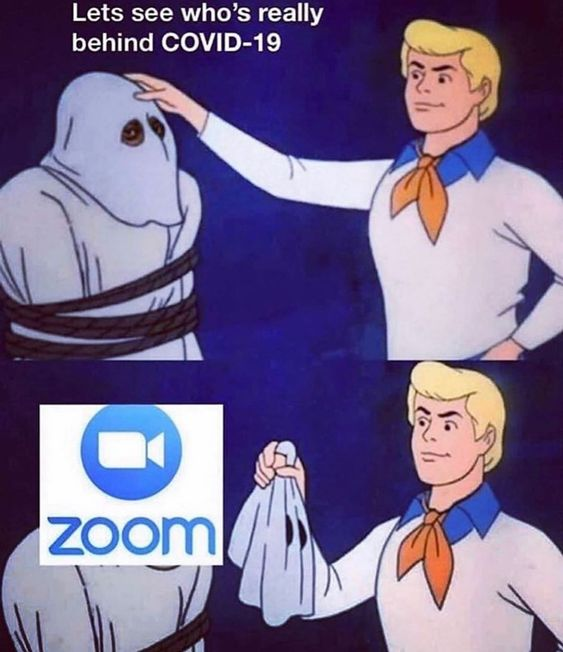

## Что было в прошлой части:

- Провели анализ данных
- Нашли пропущенные значения и заполнили их 
- Обработали нечисловые признаки 
- Придумали новый признак (feature enginreering)
- Сделали визуализацию данных
- Построили benchmark-модель

Во 2 части митапа займемся улучшением baseline модели, которая предсказывает усредненный уровень заболевших и умерших для различных регионов по всему миру. Для улучшения модели будем кодировать признаки, описывающие местоположение, добавлять новый датасет и настраивать гиперпараметры. При этом будем использовать тот же алгоритм (XGBoost). 

In [ ]:
# Подгружаем данные
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

#Путь к данным
#ВАЖНО! При локальной работе с данными поменяйте это на местоположение данных на вашей машине
df = pd.read_csv('<dataset/ML_Weekly/2/covid_train.csv>', low_memory=False)

## Воспользуемся предобработкой данных из 1 части митапа

In [ ]:
# Удалим ненужный признак
df.drop(['Id'], axis=1, inplace=True)

In [ ]:
# Берем записи только с неотрицательными значениями 'TargetValue'
df = df[(df['TargetValue'] >= 0)]

In [ ]:
# Заполнение значений NaN
df.fillna('Unknown', inplace=True)

In [ ]:
# Создадим признак 'Location', содержащий в себе всю информацию о метоположении
df['Location'] = df['Country_Region'] + '_' + df['Province_State'] + '_' + df['County']

In [ ]:
# Преобразование признака, содержащего дату к типу int
def convert_date(df, column):
    redate = pd.to_datetime(df[column], errors='coerce')
    return redate.dt.strftime('%Y%m%d').astype(int)

In [ ]:
df['Date'] = convert_date(df, 'Date')

In [ ]:
# Преобразование строковых значений признака в числовые (label encoding)
df.loc[:, 'Target'] = df['Target'].map({'Fatalities': 0, 'ConfirmedCases': 1})

In [ ]:
# Разделим датасет на тренировочную и тестовую части
train = df[df['Date'] < 20200513]
test = df[df['Date'] >= 20200513]

In [ ]:
# Выделим датасеты, содержащие информацию только о смертях
train_fatalities = train[train['Target'] == 0]
test_fatalities = test[test['Target'] == 0]

In [ ]:
# Выделим датасеты, содержащие информацию только о заболеваниях
train_cases = train[train['Target'] == 1]
test_cases = test[test['Target'] == 1]

In [ ]:
# Отделим целевой признак
def select_target_value(train, test, x, y):
    y_train = train[y]
    y_test = test[y]

    X_train = train[x]
    X_test = test[x]
    return X_train, X_test, y_train, y_test

## Label Encoding

Для признаков, характеризующих местоположениe применим label encoder.

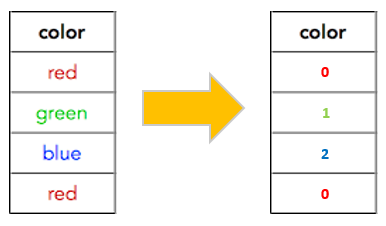

In [ ]:
df.sample()

County  Province_State  ... TargetValue                  Location
632606  Warren  North Carolina  ...           0  US_North Carolina_Warren

[1 rows x 9 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Применим label encoder для датасетов train и test
def apply_le(train, test, old_feature, new_feature):
    le = LabelEncoder()
    train[new_feature] = le.fit_transform(train[old_feature])
    test[new_feature] = le.transform(test[old_feature])
    return train, test

In [ ]:
# Обучим переданную модель, с помощью нее сделаем предсказания и вернем метрику
def apply_model(model, X_train, y_train, X_test, y_test, metric):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metric(y_test, y_pred)

In [ ]:
# Применим label encoder, выделим целевую переменную и применим модель
def model_for_le(model, train, test, old_feature, new_feature, feature_columns, target):
    train_le, test_le = apply_le(train, test, old_feature, new_feature)
    X_train, X_test, y_train, y_test = select_target_value(train_le, test_le, feature_columns, target)
    return apply_model(model, X_train, y_train, X_test, y_test, mean_absolute_error)

In [ ]:
# Применим label encoding для различных сочетаний признаков, описывающих местоположение. Для полученных датасетов применим xgboost и сравним реузльтаты
def compare_le_models(model, train, test):
    feature_cols = ['Population', 'Weight', 'Date', 'Location_label']
    location_error = model_for_le(model, train, test, 'Location', 'Location_label', feature_cols, 'TargetValue')
    print('Location error:', location_error)
    
    feature_cols = ['Population', 'Weight', 'Date', 'Country_label']
    country_error = model_for_le(model, train, test, 'Country_Region', 'Country_label', feature_cols, 'TargetValue')
    print('Country_Region:', country_error)
    
    feature_cols = ['Population', 'Weight', 'Date', 'Country_label', 'Province_label']
    state_error = model_for_le(model, train, test, 'Province_State', 'Province_label', feature_cols, 'TargetValue')
    print('Country_Region + Province_State', state_error)
    
    feature_cols = ['Population', 'Weight', 'Date', 'Country_label', 'Province_label', 'County_label']
    county_error = model_for_le(model, train, test, 'County', 'County_label', feature_cols, 'TargetValue')
    print('Country_Region + Province_State + County', county_error)
    
    return min([location_error, country_error, state_error, county_error])

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1)
le_fatalities_min_error = compare_le_models(xgb, train_fatalities, test_fatalities)

Location error: 2.2868425582033165
Country_Region: 2.395321268686176
Country_Region + Province_State 2.369393611408646
Country_Region + Province_State + County 2.369393611408646


In [ ]:
print('Минимальная ошибка при примении label encoder для смертельных случаев:', le_fatalities_min_error)

Минимальная ошибка при примении label encoder для смертельных случаев: 2.2868425582033165


In [ ]:
le_cases_min_error = compare_le_models(xgb, train_cases, test_cases)

Location error: 35.73390523926853
Country_Region: 35.60995978251148
Country_Region + Province_State 35.65838809561242
Country_Region + Province_State + County 35.65838809561242


In [ ]:
print('Минимальная ошибка при примении label encoder для случаев заболевания:', le_cases_min_error)

Минимальная ошибка при примении label encoder для случаев заболевания: 35.60995978251148


## Прменим One-hot encoding

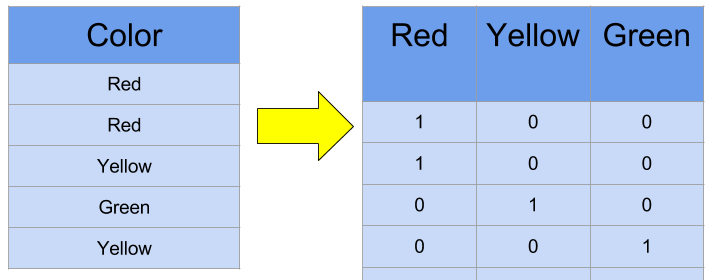

Минус label encoding заключается в том, что в кодируемом признаке появляется особый порядок. Например, Турция с кодом 42 станет больше, чем Болгария с кодом 36. Хотя это, конечно, совсем не так. После применения one-hot encoding такой проблемы не возникает, но появляются новые колонки, что может значительно замедлить процесс обучения и ухудшить модель.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

In [ ]:
# Применим one-hot encoding
def apply_ohe(train_column, test_column, df_train, df_test):
    ohe = OneHotEncoder()
    try:
        n = train_column.shape[1]
    except:
        n = 1
    train_ohe = ohe.fit_transform(train_column.values.reshape(-1, n))
    test_ohe = ohe.transform(test_column.values.reshape(-1, n))
    return sparse.hstack([train_ohe, sparse.csr_matrix(df_train)]), sparse.hstack([test_ohe, sparse.csr_matrix(df_test)])

После применения one-hot кодирования возвращается разреженная матрица (sparse matrix) в координатном формате. Она содержит только местоположение и значения ненулевых элементов. На рисунке ниже представлено преобразование разреженной матрицы в стандартном формате к координатному формату. Именно такое преобразование мы делали для исходного датасета, чтобы объеденить его с преобразованными с помощью one-hot кодирования признаками

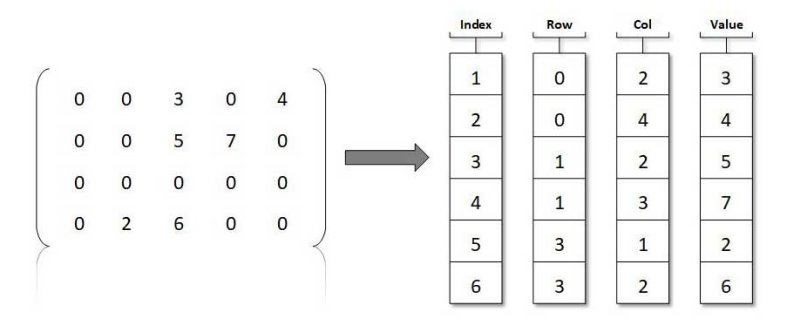

In [ ]:
# Применим one-hot encoder, выделим целевую переменную и применим модель
def model_for_ohe(model, train, test, column, feature_cols, target):
    X_train, X_test, y_train, y_test = select_target_value(train, test, feature_cols, target)
    train_ohe, test_ohe = apply_ohe(train[column], test[column], X_train, X_test)
    return apply_model(model, train_ohe, y_train, test_ohe, y_test, mean_absolute_error)

In [ ]:
# Применим one-hot encoding для различных сочетаний признаков, описывающих местоположение. Для полученных датасетов применим xgboost и сравним реузльтаты
def compare_ohe(model, train, test):
    feature_cols = ['Population', 'Weight', 'Date']
    country_error = model_for_ohe(model, train, test, 'Country_Region', feature_cols, 'TargetValue')
    print('Country_Region:', country_error)
    ohe_cols = ['Country_Region', 'Province_State']
    state_error = model_for_ohe(model, train, test, ohe_cols, feature_cols, 'TargetValue')
    print('Country_Region and Province_State:', state_error)
    ohe_cols = ['Country_Region', 'Province_State', 'County']
    county_error = model_for_ohe(model, train, test, ohe_cols, feature_cols, 'TargetValue')
    print('Country_Region, Province_State and County:', county_error)
    location_error = model_for_ohe(model, train, test, 'Location', feature_cols, 'TargetValue')
    print('Location:', model_for_ohe(model, train, test, 'Location', feature_cols, 'TargetValue'))
    
    return min([country_error, state_error, county_error, location_error])

In [ ]:
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1)
ohe_fatalities_min_error = compare_ohe(xgb, train_fatalities, test_fatalities)

Country_Region: 2.147330056349076
Country_Region and Province_State: 2.2109173153880293
Country_Region, Province_State and County: 2.190477102948179
Location: 2.2119174062440017


In [ ]:
print('Минимальная ошибка при примении one-hot encoder для смертельных случаев:', ohe_fatalities_min_error)

Минимальная ошибка при примении one-hot encoder для смертельных случаев: 2.147330056349076


In [ ]:
ohe_cases_min_error = compare_ohe(xgb, train_cases, test_cases)

Country_Region: 34.03427636039836
Country_Region and Province_State: 35.640958768896255
Country_Region, Province_State and County: 36.37684127189728
Location: 37.87408805913465


In [ ]:
print('Минимальная ошибка при примении one-hot encoder для случаев заболевания:', ohe_cases_min_error)

Минимальная ошибка при примении one-hot encoder для случаев заболевания: 34.03427636039836


Худший результат в обоих случаях показало кодирование признака Location. Это связано с тем, что из-за очень большого количество уникальных значений (почти 3500) в признаке Location создается такое же большое количество колонок. А слишком большое число признаков негативно влияет на алгоритм.

В итоге лучший вариант для смертельных случаев - one-hot кодирование признаков Country_Region и Province_State
Лучший вариант для случаев заболевания - label кодирование признака Location 

## Используем дополнительный датасет

In [ ]:
# Подгружаем датасет с характеристиками стран
countries_features = pd.read_csv('https://drive.google.com/uc?id=19KRkZFF2EEBk4kLc1e251SzM6rprGLtK')

In [ ]:
# Выведем 5 рандомных строк
countries_features.sample(5)

Country_Region  Population_Size  ...  Lockdown_Type Country_Code
84                 Italy         60421760  ...           Full          ITA
44                Cyprus          1189265  ...           Full          CYP
89                 Kenya         51393010  ...           Full          KEN
168  Trinidad and Tobago          1389858  ...           Full          TTO
86                 Japan        126529100  ...           Full          JPN

[5 rows x 11 columns]

#### Описание данных:
**Country_Region** - Название страны <br>
**Population_Size** - Население <br>
**Tourism** - уровень туризма <br>
**Date_FirstFatality** - Дата первой смерти<br>
**Date_FirstConfirmedCase** - Дата первого случая заболевания <br>
**Latitude** - Широта <br>
**Longtitude** - Долгота <br>
**Mean_Age** - Средний возраст <br>
**Lockdown_Date** - Дата введения карантина<br>
**Lockdown_Type** - Тип карантина <br>
**Country_Code** - Код страны <br>

In [ ]:
# Проверим кол-во строк со значениями NaN для каждого признака
countries_features.isnull().sum()

Country_Region              0
Population_Size             0
Tourism                     0
Date_FirstFatality         28
Date_FirstConfirmedCase     0
Latitude                    0
Longtitude                  0
Mean_Age                    0
Lockdown_Date              33
Lockdown_Type              33
Country_Code                0
dtype: int64

In [ ]:
# Заполним неопределенные значения "большим" значением
countries_features['Date_FirstFatality'].fillna('2021-01-01', inplace=True)

In [ ]:
# Посмотрим на распределение классов
countries_features['Lockdown_Type'].value_counts(dropna=False)

Full       116
Partial     35
NaN         33
Name: Lockdown_Type, dtype: int64

In [ ]:
# Выведем информацию о странах без карантина
countries_features[countries_features['Lockdown_Type'].isna()].sample(5)

Country_Region  Population_Size  ...  Lockdown_Type Country_Code
33   Central African Republic          4666377  ...            NaN          CAF
73                      Haiti         11123176  ...            NaN          HTI
70                     Guinea         12414318  ...            NaN          GIN
34                       Chad         15477751  ...            NaN          TCD
182                    Zambia         17351822  ...            NaN          ZMB

[5 rows x 11 columns]

In [ ]:
# Заполним значения NaN для признаков 'Lockdown_Date' и 'Lockdown_Type'
countries_features.loc[countries_features['Lockdown_Type'].isna(), 'Lockdown_Date'] = '2021-01-01'
countries_features.loc[countries_features['Lockdown_Type'].isna(), 'Lockdown_Type'] = 'No'

In [ ]:
countries_features.sample(10)

Country_Region  Population_Size  ...  Lockdown_Type Country_Code
80                   Iran         81800269  ...           Full          IRN
50     Dominican Republic         10627165  ...           Full          DOM
126                Norway          5311916  ...           Full          NOR
116               Morocco         36029138  ...           Full          MAR
105              Malaysia         31528585  ...           Full          MYS
119                 Nepal         28087871  ...           Full          NPL
111                Mexico        126190788  ...        Partial          MEX
53            El Salvador          6420744  ...           Full          SLV
174  United Arab Emirates          9630959  ...           Full          ARE
24                 Brunei           428962  ...             No          BRN

[10 rows x 11 columns]

In [ ]:
# Выведем информацию о Беларуси
countries_features[countries_features['Country_Region'] == 'Belarus'] 

Country_Region  Population_Size  ...  Lockdown_Type Country_Code
15        Belarus          9483499  ...           Full          BLR

[1 rows x 11 columns]

In [ ]:
# Преобразуем признаки с датой к типу int
countries_features['Date_FirstFatality'] = convert_date(countries_features, 'Date_FirstFatality')
countries_features['Date_FirstConfirmedCase'] = convert_date(countries_features, 'Date_FirstConfirmedCase')
countries_features['Lockdown_Date'] = convert_date(countries_features, 'Lockdown_Date')

In [ ]:
# Применим OrdinalEncoder, так как признак 'Lockdown_Type' порядковый: можно сказать, что полный карантин "больше" частичного, 
#а частичный "больше" отсутствия карантина
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(categories=[['No', 'Partial', 'Full']])
countries_features['Lockdown_Label'] = oe.fit_transform(countries_features['Lockdown_Type'].values.reshape(-1, 1))

In [ ]:
# Удалим фичу 'Country_Code'
countries_info = countries_features.drop(['Country_Code', 'Lockdown_Type'], axis=1)

In [ ]:
# Объединим датасеты
train_full_cases = pd.merge(train_cases, countries_info, how='inner', on='Country_Region')
test_full_cases = pd.merge(test_cases, countries_info, how='inner', on='Country_Region')

train_full_fatalities = pd.merge(train_fatalities, countries_info, how='inner', on='Country_Region')
test_full_fatalities = pd.merge(test_fatalities, countries_info, how='inner', on='Country_Region')

In [ ]:
train_full_cases.sample(3)

County Province_State  ... Lockdown_Date  Lockdown_Label
20921   Unknown   Sint Maarten  ...      20200324             2.0
329760   Oldham          Texas  ...      20200323             1.0
230287    Otero     New Mexico  ...      20200323             1.0

[3 rows x 22 columns]

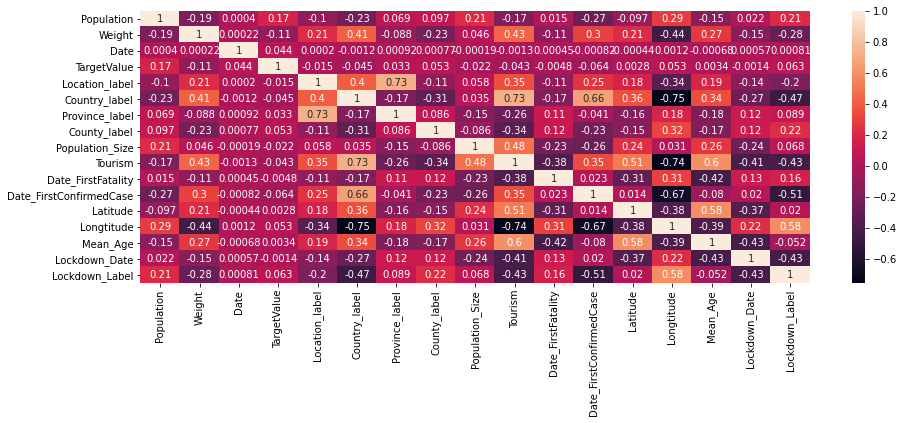

In [ ]:
# Выедем heatmap, показывающую корреляцию между признаками
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15, 5))
sns.heatmap(train_full_cases.drop('Target', axis=1).corr(), annot=True);

Проанализировав heatmap, можно найти следующие корелляционные зависимости:
- Чем меньше долгота, тем больше уровень туризма и позже произошел первый случай заболевания COVID-19.
- Чем больше широта, тем больше средний возраст.
- Чем больше средний возраст в стране, тем больше уровень туризма.

In [ ]:
# Найдем корреляцию между целевой переменной и остальными признаками
import numpy as np
np.abs(train_full_cases.drop('Target', axis=1).corr()['TargetValue'].drop('TargetValue')).sort_values(ascending=False)

Population                 0.173938
Weight                     0.105507
Date_FirstConfirmedCase    0.064140
Lockdown_Label             0.063290
Longtitude                 0.053462
County_label               0.053189
Country_label              0.044865
Date                       0.043752
Tourism                    0.043155
Province_label             0.032929
Population_Size            0.021655
Location_label             0.014847
Date_FirstFatality         0.004792
Mean_Age                   0.003441
Latitude                   0.002752
Lockdown_Date              0.001418
Name: TargetValue, dtype: float64

Максимальная корелляция с целевой перемменной наблюдается для следующих признаков: количество и плотность населения, дата первого заболевания и тип карантина.
Минимальная корелляция с целевой перемменной наблюдается для следующих признаков: дата карантина, широта, средний возрасти дата первой смерти.

Для полученных после объединения датасетов ..._full_cases и ..._full_fatalities применим следующие манипуляции:
- выделим целевую переменную для train и test частей
- для признаков, характеризующих местоположение, применим кодирование, давшее до этого наименьшую ошибку
- применим XGBRegressor

In [ ]:
useful_features = ['Population', 'Weight', 'Date', 'Population_Size', 'Tourism', 'Date_FirstFatality', 'Date_FirstConfirmedCase', 
                   'Latitude', 'Longtitude', 'Mean_Age', 'Lockdown_Date', 'Lockdown_Label']
X_train_fatalities_full, X_test_fatalities_full, y_train_fatalities_full, y_test_fatalities_full = select_target_value(train_full_fatalities, 
                                                                                       test_full_fatalities, useful_features, 'TargetValue')

In [ ]:
# Для смертельных случаев применяем one-hot encoding для признаков 'Country_Region' и 'Province_State'
ohe_cols = ['Country_Region', 'Province_State']
train_fatalities_best, test_fatalities_best = apply_ohe(train_full_fatalities[ohe_cols], test_full_fatalities[ohe_cols],
                                                        X_train_fatalities_full, X_test_fatalities_full)

In [ ]:
train_fatalities_best, test_fatalities_best

(<383653x330 sparse matrix of type '<class 'numpy.float64'>'
 	with 5367479 stored elements in COOrdinate format>,
 <100019x330 sparse matrix of type '<class 'numpy.float64'>'
 	with 1399309 stored elements in COOrdinate format>)

In [ ]:
# Для случаев заболевания применяем label encoding для признака 'Location'
useful_features += ['Location']
X_train_cases_full, X_test_cases_full, y_train_cases_full, y_test_cases_full = select_target_value(train_full_cases, test_full_cases, useful_features, 'TargetValue')
train_cases_best, test_cases_best = apply_le(X_train_cases_full, X_test_cases_full, 'Location', 'Location')

In [ ]:
train_cases_best.sample(3)

Population    Weight      Date  ...  Lockdown_Date  Lockdown_Label  Location
147710       30622  0.096810  20200125  ...       20200323             1.0      1339
236444      158714  0.083508  20200209  ...       20200323             1.0      2143
331491        6948  0.113041  20200319  ...       20200323             1.0      3004

[3 rows x 13 columns]

In [ ]:
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1)
train_fatalities_min_error = apply_model(xgb, train_fatalities_best, y_train_fatalities_full, test_fatalities_best, y_test_fatalities_full, mean_absolute_error)
print('Минимальная ошибка для смертей до добавления новых данных:', ohe_fatalities_min_error)
print('Ошибка после добавления новых данных:', train_fatalities_min_error)

Минимальная ошибка для смертей до добавления новых данных: 2.147330056349076
Ошибка после добавления новых данных: 2.2974287806644687


In [ ]:
train_cases_min_error = apply_model(xgb, train_cases_best, y_train_cases_full, test_cases_best, y_test_cases_full, mean_absolute_error)
print('Минимальная ошибка для заболеваний до добавления новых данных:', le_cases_min_error)
print('Ошибка после добавления новых данных:', train_cases_min_error)

Минимальная ошибка для заболеваний до добавления новых данных: 35.60995978251148
Ошибка после добавления новых данных: 36.40139313292161


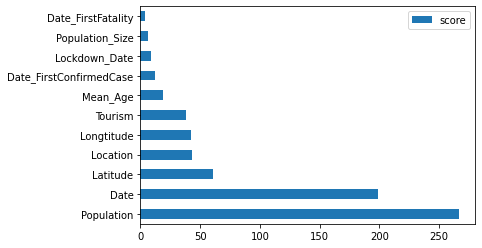

In [ ]:
# Найдем, кокое влияние на модель оказал каждый из признаков
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by ="score", ascending=False)
data.plot(kind='barh');

Наибольшее влияние для алгоритма оказали признаки из исходного датасета

## Тюнинг гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

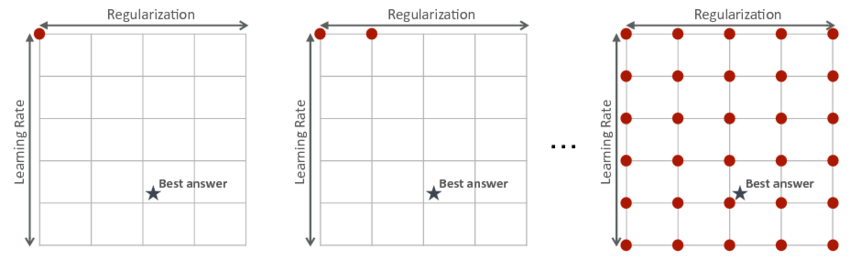

Гиперпараметры, которые будем подбирать:
  - **max_depth** - максимальная глубина дерева. Увеличение глубины сделает модель более сложной и с большей вероятностью переобучится
  - **min_child_weight** - минимальный вес узла для разделения листа на поддеревья.Чем меньше min_child_weight, тем более сложные деревья и большая вероятность переобучения.
  - **gamma** - минимальное изменение значения loss функции для разделения листа на поддеревья.
  - **subsample** - коэффициент, обозначающий какая часть объектов из train части будет использоваться при построении деревьев. Если он равен 0.5, то при построении каждого дерева будет случайным образом выбрана половина объектов, используемых для обучения.
  - **colsample_bytree** - коэффициент, обозначающий какая часть признаков будет использоваться при построении деревьев. Если он равен 0.5, то случайным образом будет выбрана половина признаков и на этих признаках будут строиться все деревья.
  - **reg_alpha** - параметр L1-регуляризации. При увеличении этого параметра модель упрощается (умеьшается вероятность переобучению, но увеличивается риск недобучиться)
  - **n_estimators** - число деревьев, влияет на длительность обучения

In [ ]:
def tune_parameters(X_train, y_train, X_test, y_test, params):
    gsearch = GridSearchCV(estimator = XGBRegressor(objective ='reg:squarederror', random_state=58), param_grid = params[0], scoring='neg_mean_absolute_error', n_jobs=-1)
    gsearch.fit(X_train, y_train)
    max_depth = gsearch.best_params_['max_depth']
    min_child_weight = gsearch.best_params_['min_child_weight']
    print(gsearch.best_params_)
    
    gsearch = GridSearchCV(estimator = XGBRegressor(objective ='reg:squarederror', random_state=58, max_depth=max_depth, min_child_weight=min_child_weight), param_grid = params[1], 
                           scoring='neg_mean_absolute_error', n_jobs=-1)
    gsearch.fit(X_train, y_train)
    gamma = gsearch.best_params_['gamma']
    print(gsearch.best_params_)
    
    gsearch = GridSearchCV(estimator = XGBRegressor(objective ='reg:squarederror', random_state=58, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma), 
                           param_grid = params[2], scoring='neg_mean_absolute_error', n_jobs=-1)
    gsearch.fit(X_train, y_train)
    subsample = gsearch.best_params_['subsample']    
    colsample_bytree = gsearch.best_params_['colsample_bytree']
    print(gsearch.best_params_)
    
    gsearch = GridSearchCV(estimator = XGBRegressor(objective ='reg:squarederror', random_state=58, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma,
                                                   subsample=subsample, colsample_bytree=colsample_bytree), 
                           param_grid = params[3], scoring='neg_mean_absolute_error', n_jobs=-1)
    gsearch.fit(X_train, y_train)
    reg_alpha = gsearch.best_params_['reg_alpha'] 
    print(gsearch.best_params_)
    
    y_pred = gsearch.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

In [ ]:
params = [{'max_depth':range(3, 10, 1),'min_child_weight':range(1, 6, 1)},
          {'gamma':[i/10.0 for i in range(0,5)]},
          {'subsample':[i/10.0 for i in range(7,11)], 'colsample_bytree':[i/10.0 for i in range(7,11)]},
          {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}]

error_cases_tuned = tune_parameters(train_cases_best, y_train_cases_full, test_cases_best, y_test_cases_full, params)
print('Минимальная ошибка для заболеваний до добавления новых данных:', le_cases_min_error)
print('Ошибка после добавления новых данных:', train_cases_min_error)
print('Ошибка после настройки параметров:', error_cases_tuned)

{'max_depth': 3, 'min_child_weight': 2}
{'gamma': 0.0}
{'colsample_bytree': 1.0, 'subsample': 0.7}
{'reg_alpha': 100}
Минимальная ошибка для заболеваний до добавления новых данных: 35.60995978251148
Ошибка после добавления новых данных: 36.40139313292161
Ошибка после настройки параметров: 34.14216532809241


После тюнинга гиперпараметров ошибка на тестовой выборке не уменьшилась, а увеличилась. Это произошло из-за переобучения. 
- **Переобучение**(англ. overfitting) — явление, когда обучаемая модель хорошо распознает примеры из обучающего множества, но при этом не распознает или плохо распознает любые другие примеры, не участвовавшие в процессе обучения.
  Противоположным событием является недообучение. 
- **Недообучение**(англ. underfitting) — явление, при котором алгоритм обучения не обеспечивает достаточно малой величины средней ошибки на обучающей выборке. Недообучение возникает при использовании недостаточно сложных моделей.


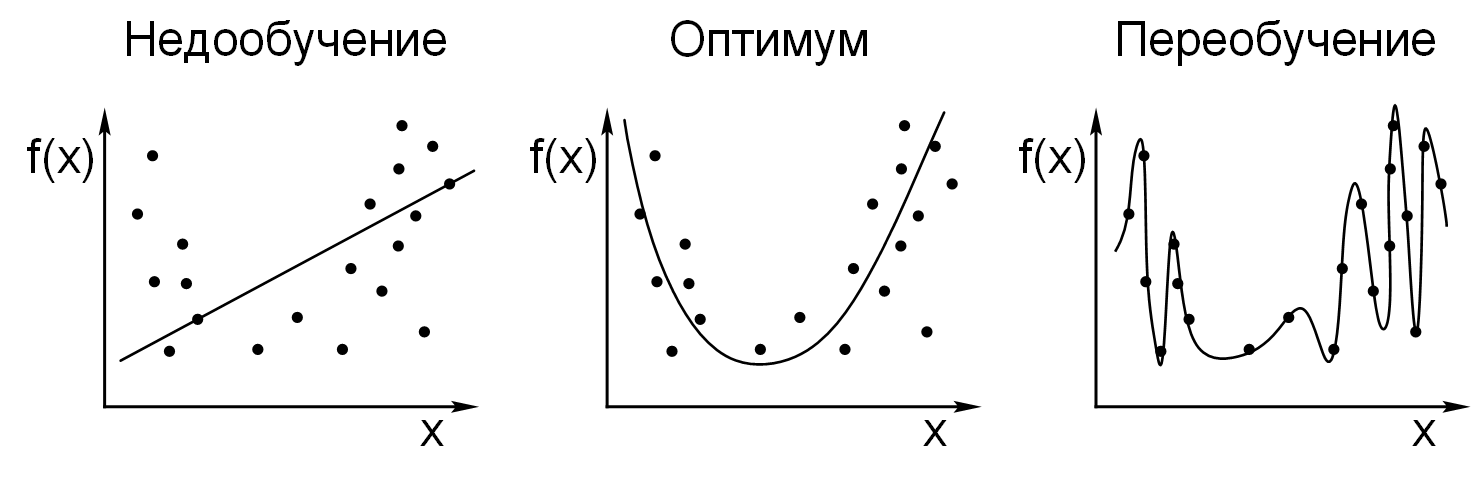

In [ ]:
error_fatalities_tuned = tune_parameters(train_fatalities_best, y_train_fatalities_full, test_fatalities_best, y_test_fatalities_full, params)
print('Минимальная ошибка для смертей до добавления новых данных:', ohe_fatalities_min_error)
print('Ошибка после добавления новых данных:', train_fatalities_min_error)
print('Ошибка после настройки параметров:', error_fatalities_tuned)

{'max_depth': 7, 'min_child_weight': 4}
{'gamma': 0.4}
{'colsample_bytree': 1.0, 'subsample': 1.0}
{'reg_alpha': 0.1}
Минимальная ошибка для смертей до добавления новых данных: 2.147330056349076
Ошибка после добавления новых данных: 2.2974287806644687
Ошибка после настройки параметров: 1.550831986589637


In [ ]:
# Увеличим количество деревьев (n_estimators) с дефолтного значения 100 до 5000
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1, n_estimators=5000, max_depth=9, min_child_weight=1, 
                            gamma=0.2, subsample=1, colsample_bytree=1, reg_alpha=0.1)
final_fatalities_error = apply_model(xgb, train_fatalities_best, y_train_fatalities_full, test_fatalities_best, y_test_fatalities_full, mean_absolute_error)
print("Ошибка после увеличения количества деревьев:", final_fatalities_error)

In [ ]:
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1, n_estimators=5000)
final_cases_error = apply_model(xgb, train_cases_best, y_train_cases_full, test_cases_best, y_test_cases_full, mean_absolute_error)
print("Ошибка после увеличения количества деревьев:", final_cases_error)

Ошибка после увеличения количества деревьев: 29.00866311393874


In [ ]:
print('Таким образом получилось снизить ошибку до ', final_fatalities_error, '(заболевания) и ', final_cases_error, '(смерти)')

In [ ]:
# Визуализируем предсказание по Беларуси
train_belarus = train_cases_best[train_cases_best['Population_Size'] == 9483499]
test_belarus = test_cases_best[test_cases_best['Population_Size'] == 9483499]
sns.lineplot(x=train_belarus["Date"].values, y=y_train_cases_full[train_belarus.index]);
sns.lineplot(x=test_belarus["Date"].values, y=y_test_cases_full[test_belarus.index]);
sns.lineplot(x=test_belarus["Date"].values, y=xgb.predict(test_belarus));

In [ ]:
# Выведем ошибку для Беларуси
y_pred_belarus = xgb.predict(test_belarus)
mean_absolute_error(y_test_cases_full[test_belarus.index], y_pred_belarus)

477.2418086610991

## Try to do yourself (optional)

Попробуйте применить алгоритм Random Forest. Обучение на всех данных займет слишком много времени, поэтому используйте первые 40 тысяч записей для тренировки и первые 10 тысяч для тестирования

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rand_forest = RandomForestRegressor(random_state=58)

In [ ]:
# Используя X_train_fatalities, y_train_fatalities, X_test_fatalities, y_test_fatalities, обучите RandomForest и посчитайте mean absolute error


In [ ]:
# Примените label encoder для разных сочетаний признаков и обучите модель


In [ ]:
# Примените one-hot encoder для разных сочетаний признаков и обучите модель.


<font color="red">В каком случае была минимальная ошибка?:</font>
1. One hot encoding для Country_Region, Province_State и State
2. One hot encoding для Location
3. Label encoding для Country_Region
4. Label encoding для Country_Region, Province_State и State

### Итог:

Во второй части митапа по глобальному прогнозированию Covid-19 проделана следующая работа:

- Улучшили Baseline модели
- Примененили label и one-hot encoding
- Добавили новый датасет
- Познакомились с гиперпараметрами XGBoost и настроили их

## Полезные ссылки

- [LabelEncoder и OneHotEncoder](https://habr.com/ru/post/456294/)
- [Grid Search](https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998)
- [Регуляризация](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0))
- [Переобучение](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9F%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5)
- [Random Forest](https://habr.com/ru/post/320726/)